In [8]:
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

sdgplt.FIGSIZE = 8

## Model sepecification
Le modèle que l'on souhaite étudier est le suivant :

$$Y_{ij} | a_{i}, b_{i} \sim \mathcal N(\eta_{ij}, 1)$$

Où $\eta_{ij} =\sum_{k=1}^p x_{ij,k} \beta_{k} + a_i$.

Avec $a_i\sim\mathcal N(0, \sigma_a^2=0.4^2)$ et $X= [U\times t, U']$ où $U$ et $ U'$ sont tiré dans une uniforme entre $[-0.1,0.1]$

Le code ci-dessous le définie pour python.

In [9]:
def m(params, times: jnp.ndarray, a, cov: jnp.ndarray, **kwargs) -> jnp.ndarray:

    out = (cov @ params.beta).reshape(times.shape) + a[:, None]  # + b[:, None] * times
    assert out.shape == times.shape
    return out

In [10]:
import functools
from jax import jit


from sdg4varselect.models import AbstractMixedEffectsModel, AbstractHDModel


class LinearMixedEffectsModel(AbstractMixedEffectsModel, AbstractHDModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMixedEffectsModel.__init__(self, N=N, J=J, **kwargs)
        self.add_latent_variables("a")
        # self.add_latent_variables("b")

    @property
    def name(self):
        return f"LMEM{self.N}_J{self.J}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.Real(shape=(1,), scale=(1,)),
            cov_latent=pc.MatrixDiagPosDef(dim=1, scale=(1,)),
            var_residual=pc.RealPositive(scale=1),
            beta=pc.Real(scale=1, shape=(self.P,)),
        )
        self.parametrization_size = self._parametrization.size

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):

        (prngkey_mem, prngkey_cov) = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        time = jnp.linspace(0.01, 1, self.J)
        time = jnp.tile(time, (self.N, 1))

        cov = jrd.uniform(
            prngkey_cov, minval=-0.1, maxval=0.1, shape=(self.N * self.J, self.P)
        )
        cov = cov.at[:, 0].set(jnp.ones(shape=(cov.shape[0],)))
        cov *= jnp.concatenate(
            [
                jnp.repeat(
                    time.reshape((self.N * self.J,))[:, None], self.P // 2, axis=-1
                ),
                jnp.ones(shape=(self.N * self.J, self.P // 2)),
            ],
            axis=-1,
        )  # cov = [cov_1*time | cov_2]

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time, cov=cov
        )

        return {"mem_obs_time": time, "cov": cov} | obs, sim

In [11]:
def plot_estimation(results, P=10):
    p_names = ["$\\mu_1$", "$\\gamma^2_{1,1}$", "$\\sigma^2$"] + [
        f"$\\beta_{{{i}}}$" for i in range(P)
    ]

    ii = [3 + i for i in range(P // 2)]

    fig = sdgplt.figure(8, 8)
    figs = sdgplt.plot_theta(
        results,
        fig=fig.subfigures(1, 2, wspace=0.07),
        params_names=p_names,
        id_to_plot=[
            [0, 1, 2],
            ii + [P // 2 + i for i in ii],
        ],
    )

    for f in figs:
        for ax in f.axes:
            ax.legend(loc="center right")

    figs[0].axes[0].set_title("Low Dimension")
    _ = figs[1].axes[0].set_title("High Dimension")

In [12]:
from copy import deepcopy
from sdg4varselect.outputs import MultiGDResults
from sdg4varselect.algo import StochasticProximalGradientDescentPrecond as SPGD
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SPGD(FIM, lbd=800, save_all=False)
algo._preconditioned_lbd = True


def one_estim(prngkey, model, data, lbd):
    prngkey_theta, prngkey = jrd.split(prngkey)
    theta0 = jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    algo.set_seed(prngkey)
    algo.lbd = lbd
    return algo.fit(model, data, theta0)


def selection_estim(prngkey, model, data, lbd):
    prngkey_selection, prngkey_estimation = jrd.split(prngkey)
    selection = one_estim(prngkey_selection, model, data, lbd)

    supp = (selection.last_theta != 0).at[: -model.P].set(True)
    dt = deepcopy(data)
    dt["cov"] = dt["cov"][:, supp[-model.P :]]

    model_shrink = deepcopy(model)
    model_shrink.P = supp[-model.P :].sum()
    model_shrink.init()
    estimation = one_estim(prngkey_estimation, model=model_shrink, data=dt, lbd=None)

    row, _ = estimation.theta.shape
    theta_expand = jnp.zeros(shape=(row, supp.shape[0]))
    estimation.theta = theta_expand.at[:, jnp.where(supp)[0]].set(estimation.theta)

    estimation.chrono += selection.chrono
    return estimation

## Simulation

Text(0.5, 0, 'Observation times')

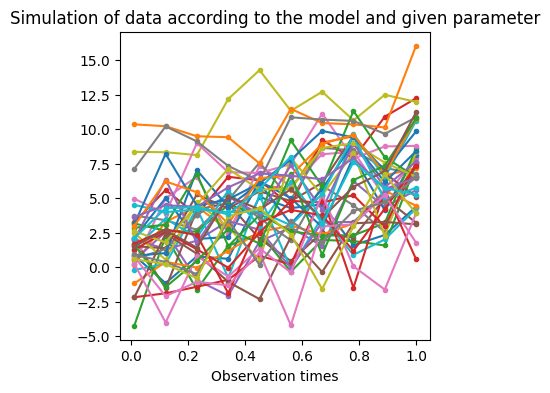

In [13]:
myModel = LinearMixedEffectsModel(N=40, J=10, P=25 * 2)

p_star = myModel.new_params(
    mean_latent=jnp.array([2]),
    cov_latent=jnp.diag(jnp.array([3**2])),
    var_residual=1,
    beta=jnp.concatenate(  # [jnp.array([5]),jnp.zeros(shape = (myModel.P-1,))
        [
            jnp.array([5, -10, 20]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
            jnp.array([-15, -5, 20]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
        ]
    ),
)

myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))
ax = sdgplt.ax(4, 4)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, ".-")
ax.set_title("Simulation of data according to the model and given parameter")
ax.set_xlabel("Observation times")

## Estimation when the support is known

0:00:50.665663
../work/finish_simu_prox/LMEM40_J10_P6_iteration SAVED !


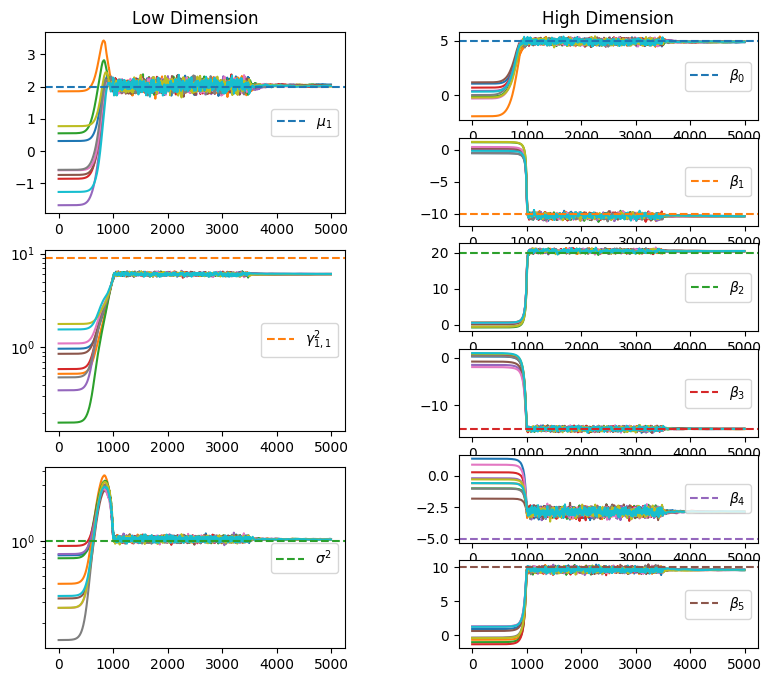

In [7]:
myModel = LinearMixedEffectsModel(N=40, J=10, P=3 * 2)
algo.init_mcmc(myModel, adaptative_sd=False)  # , sd={"b": 5, "phi2": 20})

p_star = myModel.new_params(
    mean_latent=jnp.array([2]),
    cov_latent=jnp.diag(jnp.array([3**2])),
    var_residual=1,
    beta=jnp.concatenate(  # [jnp.array([5]),jnp.zeros(shape = (myModel.P-1,))
        [
            jnp.array([5, -10, 20]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
            jnp.array([-15, -5, 10]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
        ]
    ),
)


myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

algo._preconditioned_lbd = True
algo._save_all = True
res = MultiGDResults(
    results=[one_estim(jrd.PRNGKey(i), myModel, data=myobs, lbd=None) for i in range(10)]
)
res.theta_star = p_star

print(res.chrono)
plot_estimation(res, p_star, 6)
res.save(myModel, root="../work/finish_simu_prox", filename_add_on="iteration")

## Selection

In [ ]:
from sdg4varselect._regularization_function import regularization_path

### Proximal Operator

In [ ]:
algo.save_all = True
lbd_set = 10 ** jnp.linspace(-1, 0, num=10)
algo._preconditioned_lbd = False
multi_estim = regularization_path(
    selection_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

In [ ]:
fig = sdgplt.plot_regpath(multi_estim.standardize(), P=myModel.P)
fig.axes[0].set_title("Regularization path with scalar prox")
fig.axes[1].legend(loc="best")
print(multi_estim.chrono)

In [ ]:
multi_estim.last_theta[jnp.argmin(multi_estim.ebic)]

### Weigthed Proximal Operator

In [ ]:
lbd_set = 10 ** jnp.linspace(0, 0.8, num=20)
algo._preconditioned_lbd = True
multi_estim_w = regularization_path(
    selection_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

In [ ]:
fig = sdgplt.plot_regpath(multi_estim_w.standardize(), P=myModel.P)
fig.axes[0].set_title("Regularization path with weigthed prox")
fig.axes[1].legend(loc="best")
print(multi_estim_w.chrono)

## Estimation

In [ ]:
algo._preconditioned_lbd = False
algo._save_all = True
res = MultiGDResults(
    results=[
        one_estim(jrd.PRNGKey(i), myModel, data=myobs, lbd=None) for i in range(10)
    ]
)
print(res.chrono)

In [ ]:
res = multi_estim

In [ ]:
p_names = ["$\\mu_1$", "$\\gamma^2_{1,1}$", "$\\sigma^2$"] + [
    f"$\\beta_{{{i}}}$" for i in range(myModel.P)
]

fig = sdgplt.figure(8, 8)
figs = sdgplt.plot_theta(
    res,
    fig=fig.subfigures(1, 2, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[
        [0, 1, 2],
        [3, 4, 5, 6, 7, 8] + [myModel.P // 2 + i for i in [3, 4, 5, 6, 7, 8]],
    ],
)

for f in figs:
    for ax in f.axes:
        ax.legend(loc="center right")

figs[0].axes[0].set_title("Low Dimension")
_ = figs[1].axes[0].set_title("High Dimension")

In [ ]:
res.last_theta[3:]